## Modelos lineales para clasificación

Los modelos lineales también se utilizan ampliamente para la clasificación. Veamos primero la clasificación binaria. En este caso, se realiza una predicción con la siguiente fórmula:

$$
\hat{y}= w[0]*x[0] + w[1]*x[1] + \dots +  w[p] *x[p] + b > 0
$$


La fórmula es muy similar a la de la regresión lineal, pero en lugar de simplemente devolver la suma ponderada de las características, establecemos el valor pronosticado en cero. Si la función es menor que cero, predecimos la clase `-1`; si es mayor que cero, predecimos la clase `+1`. 

Esta regla de predicción es común a todos los modelos lineales para clasificación. Nuevamente, hay muchas formas diferentes de encontrar los coeficientes `(w)` y el intercepto `(b)`.

Para los modelos lineales de regresión, la salida, $\hat{y}$, es una función lineal de las características: una línea, un plano o un hiperplano (en dimensiones superiores). Para los modelos lineales de clasificación, la frontera de decisión es una función lineal de la entrada. En otras palabras, un clasificador lineal (binario) es un clasificador que separa dos clases usando una línea, un plano o un hiperplano.

Hay muchos algoritmos para aprender modelos lineales. Todos estos algoritmos difieren en las dos formas siguientes:

*  La forma en que miden qué tan bien una determinada combinación de coeficientes e interceptos se ajustan a los datos de entrenamiento
* Si y qué tipo de regularización usan.

Diferentes algoritmos eligen diferentes formas de medir lo que significa "ajustar bien el conjunto de entrenamiento". Por razones matemáticas técnicas, no es posible ajustar `w` y `b` para minimizar el número de clasificaciones erróneas que producen los algoritmos.

In [1]:
%matplotlib inline
import numpy as np
from sklearn.datasets.samples_generator import make_blobs

def hacer_forge():
    # un conjunto de datos diseñado a mano
    X, y = make_blobs(centers=2, random_state=4, n_samples=30)
    y[np.array([7, 27])] = 0
    mascara = np.ones(len(X), dtype=np.bool)
    mascara[np.array([0, 1, 5, 26])] = 0
    X, y = X[mascara], y[mascara]
    return X, y


In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import  colorConverter

def dibuja_dispersion_discreta(x1, x2, y=None, marcadores=None, s=10, ax=None,
                     etiquetas=None, relleno=.2, alfa=1, c=None, anchobordemarcador=None):
    """Adaptacion de la funcion matplotlib.pyplot.scatter a dibujar clases o  clusters"""
    
    if ax is None:
        ax = plt.gca()

    if y is None:
        y = np.zeros(len(x1))

    unico_y = np.unique(y)

    if marcadores is None:
        marcadores= ['o', '^', 'v', 'D', 's', '*', 'p', 'h', 'H', '8', '<', '>'] * 10

    if len(marcadores) == 1:
        marcadores = marcadores * len(unico_y)

    if etiquetas is None:
        etiquetas = unico_y

    # lineas en el sentido de matplotlib
    lineas = []

    actual_cycler = mpl.rcParams['axes.prop_cycle']

    for i, (yy, cycle) in enumerate(zip(unico_y, actual_cycler())):
        mascara = y == yy
        # if c is ninguno, use color cycle
        if c is None:
            color = cycle['color']
        elif len(c) > 1:
            color = c[i]
        else:
            color = c
        # bordes claros para marcadores oscuros
        if np.mean(colorConverter.to_rgb(color)) < .4:
            colorbordemarcador = "grey"
        else:
            colorbordemarcador = "black"

        lineas.append(ax.plot(x1[mascara], x2[mascara], marcadores[i], markersize=s,
                             label=etiquetas[i], alpha=alfa, c=color,
                             markeredgewidth=anchobordemarcador,
                             markeredgecolor=colorbordemarcador)[0])

    if relleno != 0:
        pad1 = x1.std() * relleno
        pad2 = x2.std() * relleno
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
        ax.set_xlim(min(x1.min() - pad1, xlim[0]), max(x1.max() + pad1, xlim[1]))
        ax.set_ylim(min(x2.min() - pad2, ylim[0]), max(x2.max() + pad2, ylim[1]))

    return lineas

In [3]:
from matplotlib.colors import ListedColormap
cm2 = ListedColormap(['#0000aa', '#ff2020'])

def dibuja_separador_2d(clasificador, X, relleno=False, ax=None, eps=None, alfa=1,
                      cm=cm2, ancholinea=None, umbral=None,
                      estilolinea="solid"):

    if eps is None:
        eps = X.std() / 2.

    if ax is None:
        ax = plt.gca()

    x_min, x_max = X[:, 0].min() - eps, X[:, 0].max() + eps
    y_min, y_max = X[:, 1].min() - eps, X[:, 1].max() + eps
    xx = np.linspace(x_min, x_max, 1000)
    yy = np.linspace(y_min, y_max, 1000)

    X1, X2 = np.meshgrid(xx, yy)
    X_grid = np.c_[X1.ravel(), X2.ravel()]
    try:
        valor_decision = clasificador.decision_function(X_grid)
        niveles = [0] if umbral is None else [umbral]
        niveles_f = [valor_decision.min()] + niveles + [valor_decision.max()]
    except AttributeError:
        # No funciones de decision
        valor_decision = clasificador.predict_proba(X_grid)[:, 1]
        niveles = [.5] if umbral is None else [umbral]
        niveles_f = [0] + niveles + [1]
    if relleno:
        ax.contourf(X1, X2, valor_decision.reshape(X1.shape),
                    levels=niveles_f, alpha=alfa, cmap=cm)
    else:
        ax.contour(X1, X2, valor_decision.reshape(X1.shape), levels=niveles,
                   colors="black", alpha=alfa, linewidths=ancholinea,
                   linestyles=estilolinea, zorder=5)

    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks(())
    ax.set_yticks(())

Podemos aplicar los modelos LogisticRegression y LinearSVC al conjunto de datos `forge` y visualizar la frontera  de decisión tal como lo encontraron los modelos lineales:

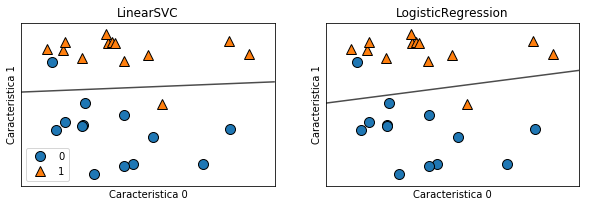

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
X, y = hacer_forge()
fig, axes = plt.subplots(1, 2, figsize=(10, 3))

for model, ax in zip([LinearSVC(), LogisticRegression()], axes):
    clasificador1 = model.fit(X, y)
    dibuja_separador_2d(clasificador1, X, relleno=False, eps=0.5,ax=ax, alfa=.7)
    dibuja_dispersion_discreta(X[:, 0], X[:, 1], y, ax=ax)
    ax.set_title("{}".format(clasificador1.__class__.__name__))
    ax.set_xlabel("Caracteristica 0")
    ax.set_ylabel("Caracteristica 1")
    axes[0].legend()

En esta figura, tenemos la primera característica del conjunto de datos `forge` en el eje x y la segunda característica en el eje y, como antes. Mostramos los límites de decisión encontrados por `LinearSVC` y `LogisticRegression` respectivamente como líneas rectas, separando el área clasificada como clase `1` en la parte superior del área clasificada  y como clase `0` en la parte inferior.

En otras palabras, cualquier punto de datos nuevo que se encuentre por encima de la línea negra será clasificado como clase `1` por el clasificador respectivo, mientras que cualquier punto que se encuentre debajo de la línea negra se clasificará como clase `0`.

Los dos modelos presentan límites de decisión similares. Tenga en cuenta que ambos clasifican erróneamente dos de los puntos. Por defecto, ambos modelos aplican una regularización L2, de la misma manera que Ridge lo hace para la regresión.

Para `LogisticRegression` y `LinearSVC`, el parámetro `trade-off` que determina la intensidad de la regularización se llama `C` y los valores más altos de C corresponden a una menor regularización.

En otras palabras, cuando usa un valor alto para el parámetro C, LogisticRegression y LinearSVC intentan ajustar el conjunto de entrenamiento de la mejor manera posible, mientras que con valores bajos del parámetro C, los modelos ponen más énfasis en encontrar un vector de coeficiente `(w )` que esté cerca de cero.

Hay otro aspecto interesante de cómo actúa el parámetro C. Usar valores bajos de C hará que los algoritmos intenten ajustarse a la "mayoría" de los puntos de datos, mientras que usar un valor más alto de C subraya la importancia de que cada punto de datos individual se clasifique correctamente.

In [5]:
from sklearn.svm import LinearSVC

def dibuja_regularizacion_svc_lineal():
    X, y = make_blobs(centers=2, random_state=4, n_samples=30)
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    # un conjunto de datos diseñado a mano 
    y[7] = 0
    y[27] = 0
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5

    for ax, C in zip(axes, [1e-2, 10, 1e3]):
        dibuja_dispersion_discreta(X[:, 0], X[:, 1], y, ax=ax)
        svm = LinearSVC(C=C, tol=0.00001, dual=False).fit(X, y)
        w = svm.coef_[0]
        a = -w[0] / w[1]
        xx = np.linspace(6, 13)
        yy = a * xx - (svm.intercept_[0]) / w[1]
        ax.plot(xx, yy, c='k')
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)
        ax.set_xticks(())
        ax.set_yticks(())
        ax.set_title("C = %f" % C)
        axes[0].legend(loc="best")

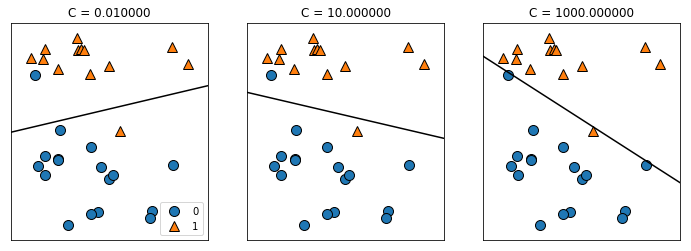

In [6]:
dibuja_regularizacion_svc_lineal()

En el lado izquierdo, tenemos una C muy pequeña que corresponde a mucha regularización. La mayoría de los puntos en la clase 0 están en la parte superior, y la mayoría de los puntos en la clase 1 están en la parte inferior. El modelo fuertemente regularizado elige una línea relativamente horizontal, clasificando erróneamente dos puntos. En el gráfico central, C es ligeramente más alto, y el modelo se centra más en las dos muestras mal clasificadas, inclinando el límite de decisión.

Finalmente, en el lado derecho, el valor muy alto de C en el modelo inclina mucho el límite de decisión, ahora clasifica correctamente todos los puntos en la clase 0. Uno de los puntos en la clase 1 todavía está mal clasificado, ya que no es posible corregirlo correctamente en este conjunto de datos usando una línea recta.

El modelo ilustrado en el lado derecho trata de clasificar correctamente todos los puntos, pero puede que no capture bien el diseño general de las clases. En otras palabras, es probable que este modelo esté sobreajustado.

Nuevamente, en dimensiones elevadas, los modelos lineales para la clasificación se vuelven muy potentes, y la protección contra el sobreajuste es cada vez más importante cuando se consideran más características.

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer
cancer = load_breast_cancer()
X_entrenamiento, X_prueba, y_entrenamiento, y_prueba = train_test_split( cancer.data, cancer.target, 
                                            stratify=cancer.target, random_state=42)
logreg = LogisticRegression().fit(X_entrenamiento, y_entrenamiento)
print("Puntuacion del conjunto de entrenamiento: {:.3f}".format(logreg.score(X_entrenamiento, y_entrenamiento)))
print("Puntuacion del conjunto de prueba: {:.3f}".format(logreg.score(X_prueba, y_prueba)))

Puntuacion del conjunto de entrenamiento: 0.953
Puntuacion del conjunto de prueba: 0.958


El valor predeterminado de C = 1 proporciona un rendimiento bastante bueno, con un 95% de precisión tanto en el entrenamiento como en el conjunto de prueba. Pero como el entrenamiento y el rendimiento del conjunto de pruebas son muy similares, es probable que tengamos sobreajuste. Probemos aumentar C para adaptarnos a un modelo más flexible:

In [8]:
logreg100 = LogisticRegression(C=100).fit(X_entrenamiento, y_entrenamiento)
print("Puntuacion del conjunto de entrenamiento: {:.3f}".format(logreg100.score(X_entrenamiento, y_entrenamiento)))
print("Puntuacion del conjunto de prueba: {:.3f}".format(logreg100.score(X_prueba, y_prueba)))

Puntuacion del conjunto de entrenamiento: 0.972
Puntuacion del conjunto de prueba: 0.965


El uso de C = 100 da como resultado una mayor precisión del conjunto de entrenamiento y también una precisión ligeramente mayor en el conjunto de pruebas, lo que confirma nuestra intuición de que un modelo más complejo debería funcionar mejor.

También podemos investigar qué sucede si utilizamos un modelo aún más regularizado que el valor predeterminado de C = 1, configurando C = 0.01:

In [9]:
logreg001 = LogisticRegression(C=0.01).fit(X_entrenamiento, y_entrenamiento)
print("Puntuacion del conjunto de entrenamiento: {:.3f}".format(logreg001.score(X_entrenamiento, y_entrenamiento)))
print("Puntuacion del conjunto de prueba: {:.3f}".format(logreg001.score(X_prueba, y_prueba)))

Puntuacion del conjunto de entrenamiento: 0.934
Puntuacion del conjunto de prueba: 0.930


Como era de esperar, cuando se mueve más hacia la izquierda a lo largo de la escala que se muestra en le gráfico entre la complejidad del modelo y la precisión del conjunto de entrenamiento y prueba desde un  modelo subfijado, tanto la precisión del entrenamiento como la del conjunto de pruebas disminuyen con respecto a los parámetros predeterminados.

Finalmente, veamos los coeficientes aprendidos por los modelos con las tres configuraciones diferentes del parámetro de regularización C.

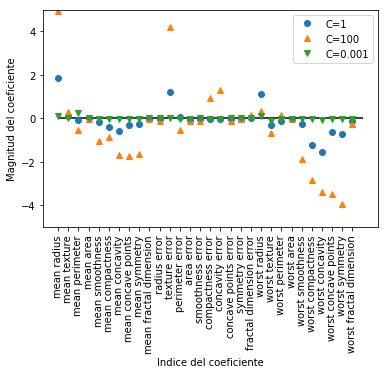

In [10]:
plt.plot(logreg.coef_.T, 'o', label="C=1")
plt.plot(logreg100.coef_.T, '^', label="C=100")
plt.plot(logreg001.coef_.T, 'v', label="C=0.001")
plt.xticks(range(cancer.data.shape[1]), cancer.feature_names, rotation=90)
plt.hlines(0, 0, cancer.data.shape[1])
plt.ylim(-5, 5)
plt.xlabel("Indice del coeficiente")
plt.ylabel("Magnitud del coeficiente")
plt.legend()

Como LogisticRegression aplica una regularización L2 por defecto, el resultado es similar al producido por Ridge.

Una regularización más fuerte empuja los coeficientes cada vez más hacia cero, aunque los coeficientes nunca llegan a ser exactamente cero. Al inspeccionar el gráfico más de cerca, también podemos ver un efecto interesante en el tercer coeficiente, `mean perimeter`.

Para C = 100 y C = 1, el coeficiente es negativo, mientras que para C = 0.001, el coeficiente es positivo, con una magnitud que es incluso mayor que para C = 1. Al interpretar un modelo como este, uno podría pensar que el coeficiente nos dice a qué clase está asociada una característica.

Por ejemplo, uno podría pensar que una característica alta de "texture error"  está relacionada con una muestra que es "maligna". Sin embargo, el cambio de signo en el coeficiente de "mean perimeter" significa que, dependiendo del modelo que consideremos, un alto "perímetro medio" podría tomarse como indicativo de "benigno" o indicativo de "maligno". Esto ilustra que las interpretaciones de los coeficientes de los modelos lineales siempre deben tomarse con un grano de sal.


Si deseamos un modelo más interpretable, el uso de la regularización L1 podría ayudar, ya que limita el modelo a usar solo algunas características.

Precision de entrenamiento con l1 de regresion logistica con C=0.001: 0.91
Precision de prueba con l1 de regresion logistica con C=0.001: 0.92
Precision de entrenamiento con l1 de regresion logistica con C=1.000: 0.96
Precision de prueba con l1 de regresion logistica con C=1.000: 0.96
Precision de entrenamiento con l1 de regresion logistica con C=100.000: 0.99
Precision de prueba con l1 de regresion logistica con C=100.000: 0.98


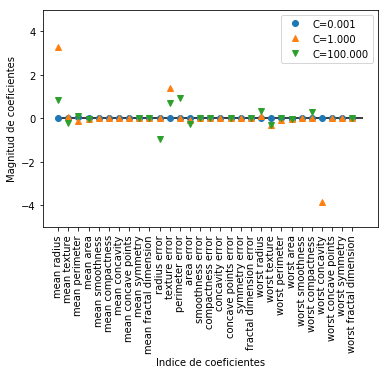

In [11]:
for C, marker in zip([0.001, 1, 100], ['o', '^', 'v']):
    lr_l1 = LogisticRegression(C=C, penalty="l1").fit(X_entrenamiento, y_entrenamiento)
    print("Precision de entrenamiento con l1 de regresion logistica con C={:.3f}: {:.2f}".format( C,
                        lr_l1.score(X_entrenamiento, y_entrenamiento)))
    print("Precision de prueba con l1 de regresion logistica con C={:.3f}: {:.2f}".format(C, 
                                lr_l1.score(X_prueba, y_prueba)))
    plt.plot(lr_l1.coef_.T, marker, label="C={:.3f}".format(C))

plt.xticks(range(cancer.data.shape[1]), cancer.feature_names, rotation=90)
plt.hlines(0, 0, cancer.data.shape[1])
plt.xlabel("Indice de coeficientes")
plt.ylabel("Magnitud de coeficientes")
plt.ylim(-5, 5)
plt.legend()

Como se puede ver, existen muchos paralelismos entre los modelos lineales para la clasificación binaria y los modelos lineales para la regresión. Como en la regresión, la principal diferencia entre los modelos es el parámetro `penalty`, que influye en la regularización y si el modelo utilizará todas las características disponibles o seleccionará solo un subconjunto.

### Modelos lineales para clasificación multiclase

Muchos modelos de clasificación lineal son únicamente para la clasificación binaria y no se extienden naturalmente al caso multiclase (con la excepción de la regresión logística). Una técnica común para extender un algoritmo de clasificación binario a un algoritmo de clasificación multiclase es el enfoque `one-vs. rest`.

En este enfoque se aprende un modelo binario para cada clase que intenta separar esa clase de todas las otras clases, lo que da como resultado tantos modelos binarios como clases. Para hacer una predicción, todos los clasificadores binarios se ejecutan en un punto de prueba. El clasificador que tiene la puntuación más alta en su clase individual "gana", y esta etiqueta de clase se devuelve como predicción.

Tener un clasificador binario por clase resulta en tener un vector de coeficientes `(w)` y un intercepto `(b)` para cada clase. La clase para la cual el resultado de la fórmula de confianza de clasificación dada aquí es la más alta es la etiqueta de clase asignada:

$$
w[0]*x[0] + w[1]*x[1] + \dots +  w[p] *x[p] + b 
$$

Las matemáticas detrás de la regresión logística multiclase difieren un poco del enfoque `one-vs.rest`, pero también dan como resultado un vector de coeficiente e intersección por clase y se aplica el mismo método de hacer una predicción.

#### Ejemplo

Vamos a aplicar el método `one-vs. rest` a un conjunto de datos de clasificación simple de tres clases. Usamos un conjunto de datos bidimensional, donde cada clase está dada por datos muestreados de una distribución Gaussiana.


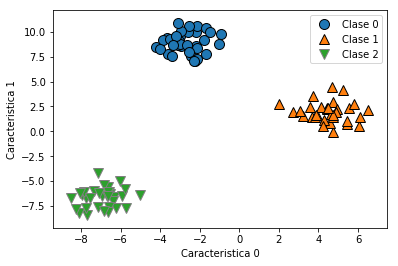

In [12]:
from sklearn.datasets import make_blobs
X, y = make_blobs(random_state=42)
dibuja_dispersion_discreta(X[:, 0], X[:, 1], y)
plt.xlabel("Caracteristica 0")
plt.ylabel("Caracteristica 1")
plt.legend(["Clase 0", "Clase 1", "Clase 2"])

Ahora, entrenamos un clasificador LinearSVC en el conjunto de datos:

In [13]:
svm_lineal = LinearSVC().fit(X, y)
print("Dimension coeficiente: ", svm_lineal.coef_.shape)
print("Dimension intercepto: ", svm_lineal.intercept_.shape)

Dimension coeficiente:  (3, 2)
Dimension intercepto:  (3,)


Vemos que la dimensión del `coef_` es (3, 2), lo que significa que cada fila de `coef_` contiene el vector de coeficientes para una de las tres clases y cada columna contiene el valor del coeficiente para una característica específica (hay dos en este conjunto de datos) . 

El `intercept_` ahora es una matriz unidimensional, almacenando las intersecciones para cada clase. Visualicemos las líneas dadas por los tres clasificadores binarios:

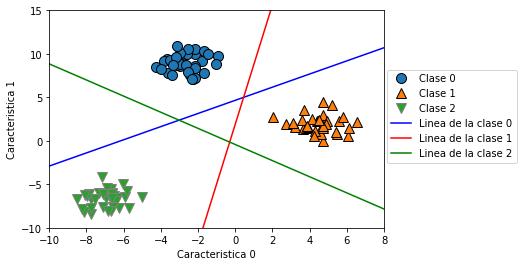

In [14]:
dibuja_dispersion_discreta(X[:, 0], X[:, 1], y)
linea = np.linspace(-15, 15)
for coef, intercepto, color in zip(svm_lineal.coef_, svm_lineal.intercept_,['b', 'r', 'g']):
    plt.plot(linea, -(linea * coef[0] + intercepto) / coef[1], c=color)
plt.ylim(-10, 15)
plt.xlim(-10, 8)
plt.xlabel("Caracteristica 0")
plt.ylabel("Caracteristica 1")
plt.legend(['Clase 0', 'Clase 1', 'Clase 2', 'Linea de la clase 0', 'Linea de la clase 1', 'Linea de la clase 2'],
           loc=(1.01, 0.3))

Puede ver que todos los puntos que pertenecen a la `clase 0` en los datos de entrenamiento están por encima de la línea correspondiente a la `clase 0`, lo que significa que están en el lado de "clase 0" de este clasificador binario. 

Los puntos en la `clase 0` están por encima de la línea correspondiente a la `clase 2`, lo que significa que están clasificados como "resto" por el clasificador binario para la `clase 2`. Los puntos pertenecientes a la `clase 0` están a la izquierda de la línea correspondiente a la `clase 1`, que significa que el clasificador binario para la `clase 1` también los clasifica como "resto".

Por lo tanto, cualquier punto en esta área será clasificado como `clase 0` por el clasificador final (el resultado de la fórmula de confianza de clasificación para el clasificador 0 es mayor que cero, mientras que es menor que cero para las otras dos clases).

¿Pero qué hay del triángulo en el medio del gráfico? Los tres clasificadores binarios clasifican los puntos como "resto". ¿A qué clase se asignaría un punto? La respuesta es a la que tiene el valor más alto para la fórmula de clasificación: la clase de la línea más cercana.

Mostremos todas las predicciones para todas las regiones del espacio de dos dimensiones.

In [15]:
from matplotlib.colors import ListedColormap
cm3 = ListedColormap(['#0000aa', '#ff2020', '#50ff50'])
def dibuja_clasificacion_2d(clasificador, X, relleno=False, ax=None, eps=None, alfa=1, cm=cm3):
    # multiclase
    if eps is None:
        eps = X.std() / 2.

    if ax is None:
        ax = plt.gca()

    x_min, x_max = X[:, 0].min() - eps, X[:, 0].max() + eps
    y_min, y_max = X[:, 1].min() - eps, X[:, 1].max() + eps
    xx = np.linspace(x_min, x_max, 1000)
    yy = np.linspace(y_min, y_max, 1000)

    X1, X2 = np.meshgrid(xx, yy)
    X_grid = np.c_[X1.ravel(), X2.ravel()]
    valores_decision = clasificador.predict(X_grid)
    ax.imshow(valores_decision.reshape(X1.shape), extent=(x_min, x_max,
                        y_min, y_max), aspect='auto', origin='lower', alpha=alfa, cmap=cm)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks(())
    ax.set_yticks(())

Text(0,0.5,'Caracteristica 1')

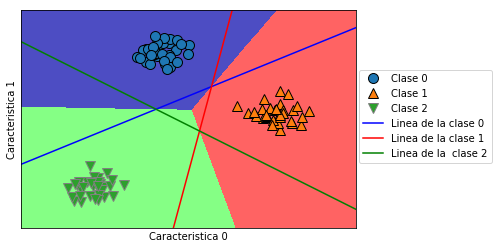

In [16]:
dibuja_clasificacion_2d(svm_lineal, X, relleno=True, alfa=.7)
dibuja_dispersion_discreta(X[:, 0], X[:, 1], y)
linea = np.linspace(-15, 15)
for coef, intercepto, color in zip(svm_lineal.coef_, svm_lineal.intercept_, ['b', 'r', 'g']):
    plt.plot(linea, -(linea * coef[0] + intercepto) / coef[1], c=color)

plt.legend(['Clase 0', 'Clase 1', 'Clase 2', 'Linea de la clase 0', 'Linea de la clase 1',
'Linea de la  clase 2'], loc=(1.01, 0.3))
plt.xlabel("Caracteristica 0")
plt.ylabel("Caracteristica 1")

### Fortalezas, debilidades y paramétros

El parámetro principal de los modelos lineales es el parámetro de regularización, llamado `alpha` en los modelos de regresión y C en LinearSVC y LogisticRegression. Los valores grandes para valores `alpha` o pequeños para C significan modelos simples.

En particular para los modelos de regresión, ajustar estos parámetros es bastante importante. Por lo general, C y `alpha` se buscan en una escala logarítmica. La otra decisión que debe tomar es si desea usar la regularización L1 o la regularización L2. 

Si supone que solo algunas de sus características son realmente importantes, debe usar L1, de lo contrario, deberías usar el valor predeterminado L2.L1 también puede ser útil si la interpretabilidad del modelo es importante. Como L1 solo usará algunas características, es más fácil explicar qué características son importantes para el modelo y cuáles son los efectos de estas características.

Los modelos lineales son muy rápidos de entrenar, y también rápidos de predecir. Escalan a conjuntos de datos muy grandes y funcionan bien con datos dispersos. Si sus datos constan de cientos de miles o millones de muestras, es posible que desee investigar utilizando la opción `solver = 'sag'` en LogisticRegression y Ridge, que puede ser más rápido que el predeterminado en grandes conjuntos de datos. 

Otras opciones son la clase SGDClassifier y la clase SGDRegressor, que implementan versiones aún más escalables de los modelos lineales que se describen aquí.

Otra ventaja de los modelos lineales es que hacen que sea relativamente fácil comprender cómo se realiza una predicción, utilizando las fórmulas que vimos anteriormente para la regresión y la clasificación. Desafortunadamente, a menudo no está del todo claro por qué los coeficientes son como son. Esto es particularmente cierto si su conjunto de datos tiene características altamente correlacionadas; en estos casos, los coeficientes pueden ser difíciles de interpretar.

Los modelos lineales a menudo funcionan bien cuando el número de características es grande en comparación con el número de muestras. También se usan a menudo en conjuntos de datos muy grandes, simplemente porque no es posible entrenar otros modelos. Sin embargo, en los espacios de dimensiones inferiores, otros modelos podrían ofrecer un mejor rendimiento de generalización. 


### Clasificador Naive Bayes

Los clasificadores Naive Bayes son una familia de clasificadores que son bastante similares a los modelos lineales discutidos anteriormente. Sin embargo, tienden a ser incluso más rápidos en el entrenamiento.

El precio a pagar por esta eficiencia es que los modelos Naive Bayes a menudo proporcionan un rendimiento de generalización un poco peor que el de los clasificadores lineales como LogisticRegression y LinearSVC. La razón por la cual los modelos Naives Bayes son tan eficientes es que aprenden los parámetros al observar cada característica individualmente y recopilan estadísticas simples por clase de cada característica.

Hay 3 tipos de clasificadores Naive Bayes implementados en scikit-learn:

* GaussianNB: aplicado a variables continuas.
* BernoulliNB: asume datos binarios
* MultinomialNB: asume datos de conteo (es decir, que cada característica representa un conteo entero de algo, como la frecuencia con que aparece una palabra en una oración).

El clasificador `BernoulliNB` cuenta con qué frecuencia cada característica de cada clase no es cero.

In [17]:
X = np.array([[0, 1, 0, 1], 
              [1, 0, 1, 1], 
              [0, 0, 0, 1],
              [1, 0, 1, 0]])
y = np.array([0, 1, 0, 1])

Aquí, tenemos cuatro puntos de datos, con cuatro características binarias cada uno. Hay dos clases 0 y 1. Para la `clase 0` (el primer y tercer punto de datos), la primera característica es cero dos veces y cero distintas de cero, la segunda característica es cero una vez y distinta de cero una vez, y así sucesivamente. 

```
0 1 0 1
0 0 0 1
```


Estos mismos recuentos se calculan para los puntos de datos en la segunda clase. 

Contando las entradas distintas de cero por clase en esencia se ve así:

In [18]:
contador = {}
# iteramos sobre cada clase.
# contar (suma) entradas de 1 por caracteristica
for etiqueta  in np.unique(y):
    contador[etiqueta] = X[y == etiqueta].sum(axis=0)
print("Conteo de caracteristica:\n{}".format(contador))

Conteo de caracteristica:
{0: array([0, 1, 0, 2]), 1: array([2, 0, 2, 1])}


Los otros dos modelos Naive Bayes, MultinomialNB y GaussianNB, son ligeramente diferentes en el tipo de estadísticas que calculan. MultinomialNB tiene en cuenta el valor promedio de cada característica para cada clase, mientras que GaussianNB almacena el valor promedio así como también la desviación estándar de cada característica para cada clase.

Para hacer una predicción, se compara un punto de datos con las estadísticas para cada una de las clases, y se predice la mejor clase de coincidencia. Curiosamente, tanto para MultinomialNB como para BernoulliNB, esto conduce a una fórmula de predicción que es de la misma forma que en los modelos lineales .

Desafortunadamente, `coef_` para los modelos Naive Bayes tiene un significado algo diferente que en los modelos lineales, en el que `coef_` no es lo mismo que `w`.

### Fortalezas, debilidades y paramétros

MultinomialNB y BernoulliNB tienen un solo parámetro,`alpha`, que controla la complejidad del modelo. La forma en que `alpha` funciona es que el algoritmo agrega a los datos  muchos puntos de datos virtuales que tienen valores positivos para todas las características. Esto da como resultado un "suavizado" de las estadísticas.

Un `alpha` grande significa más suavizado, lo que resulta en modelos menos complejos. El rendimiento del algoritmo es relativamente robusto a la configuración de `alpha`, lo que significa que la configuración de `alpha` no es crítica para un buen rendimiento. Sin embargo, ajustarlo generalmente mejora la precisión .

GaussianNB se usa principalmente en datos de muy alta dimensión, mientras que las otras dos variantes de Naive  Bayes se usan ampliamente para datos de conteo disperso como  texto.

Normalmente, MultinomialNB funciona mejor que BinaryNB, particularmente en conjuntos de datos con un número relativamente grande de características diferentes de cero (es decir, documentos grandes).

Los modelos Naive Bayes comparten muchas de las fortalezas y debilidades de los modelos lineales. Son muy rápidos para entrenar y predecir y el procedimiento de entrenamiento es fácil de entender. Los modelos funcionan muy bien con datos escasamente dimensionales y son relativamente robustos para los parámetros. Los modelos de Naive Bayes son excelentes modelos de referencia y, a menudo, se utilizan en conjuntos de datos muy grandes, donde el entrenamiento, incluso un modelo lineal, puede llevar demasiado tiempo.
